# 3章

In [1]:
%matplotlib inline

## ライブラリのインポート

In [2]:
import numpy as np
import matplotlib.pylab as plt

In [3]:
def draw_graph(f,ylim=(-0.1,1.1)):
    X = np.arange(-5.0,5.0,0.1)
    Y = f(X)
    plt.plot(X,Y)
    plt.ylim(ylim[0],ylim[1])

## ステップ関数

階段のように段差のあるグラフとなる。

$$
\begin{cases}
    1 & (x > 0) \\
    0 & (x < 0)
\end{cases}
$$

```python3
np.array(x > 0,dtype=np.int)
```
xが0より大きいとき、この行はTrueの配列となる。

TrueはPythonでは1として、Falseは0として扱われる。

そのためx=0を境にy値が0から1に変化する。

In [4]:
def step_function(x):
    return np.array(x > 0,dtype=np.int)

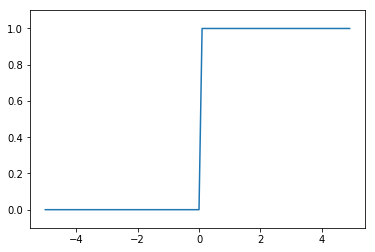

In [5]:
draw_graph(step_function)
plt.show()

## シグモイド関数

$$
sigmoid(x) = \frac{1}{1 + \mathrm{e}^{-x}}
$$

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

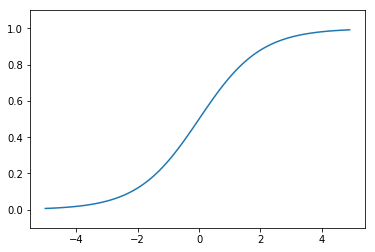

In [7]:
draw_graph(sigmoid)
plt.show()

# シグモイド関数とステップ関数の比較

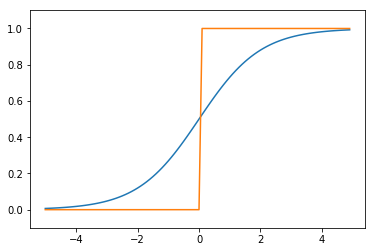

In [8]:
x = np.arange(-5.0,5.0,0.1)
y1 = sigmoid(x)
y2 = step_function(x)

plt.plot(x,y1)
plt.plot(x,y2)
plt.ylim(-0.1,1.1)
plt.show()

# ReLu関数(Rectified Linear Unit 関数)

$$
\begin{cases}
    x & (x > 0) \\
    0 & (x \le 0)
\end{cases}
$$

In [9]:
def relu(x):
    return np.maximum(0,x)

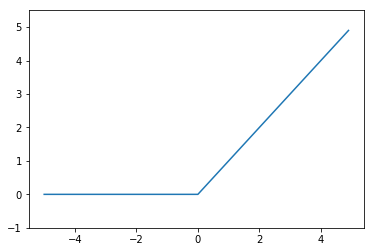

In [10]:
draw_graph(relu,(-1.0,5.5))

# MNISTを見てみる

### 追加ライブラリのインポート

In [11]:
import sys,os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from PIL import Image

### 画像の表示
```python3
(x_train,t_train),(x_test,t_test) = load_mnist(flatten=True,normalize=False)
```
この行では\*_trainでトレーニングデータのロード、\*_testでテストデータのロードをする。

5
(784,)
(28, 28)


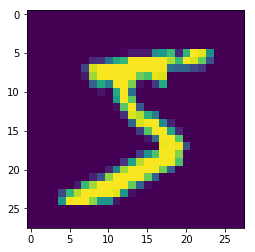

In [12]:
(x_train,t_train),(x_test,t_test) = load_mnist(flatten=True,normalize=False)
img = x_train[0]
label = t_train[0]
print(label)

print(img.shape)
img = img.reshape(28,28)
print(img.shape)

plt.imshow(img)

# 学習済みニューラルネットワークで認識率を見てみる

In [13]:
# 追加ライブラリのインポート
import pickle
from common.functions import sigmoid,softmax

In [14]:
def get_data():
    (x_train,t_train),(x_test,t_test) = load_mnist(normalize=True,flatten=True,one_hot_label=False)
    return x_test,t_test

### ネットワークの初期化

今回は学習済みネットワークを使うのでpythonのpickleファイルであるsample_weight.pklをロードしている。

In [15]:
def init_network():
    with open("sample_weight.pkl",'rb') as f:
        network = pickle.load(f)
    return network

In [16]:
def predict(network,x):
    W1,W2,W3 = network['W1'],network['W2'],network['W3']
    b1,b2,b3 = network['b1'],network['b2'],network['b3']
    
    a1 = np.dot(x,W1) + b1
    z1 = sigmoid(a1)
    
    a2 = np.dot(z1,W2) + b2
    z2 = sigmoid(a2)
    
    a3 = np.dot(z2,W3) + b3
    y = softmax(a3)
    
    return y

### 画像データのロード

```python3
x,t = get_data()
```

xには画像データが1万個、tにはラベルデータが１万個入っている。

get_data関数で取得した画像データは１次元に変換されているためnumpyのreshape関数により2次元データに直して表示する。

(10000, 784)
(10000,)
7


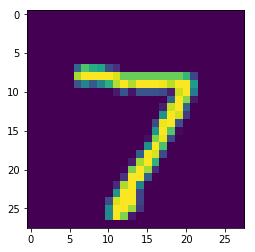

In [17]:
x,t = get_data()
print(x.shape)
print(t.shape)
print(t[0])
plt.imshow(x[0].reshape(28,28))

In [18]:
network = init_network()
accuracy_cnt = 0
for i in range(len(x)):
    y = predict(network,x[i])
    p = np.argmax(y)
    if p == t[i]:
        accuracy_cnt += 1
        
print("Accuracy:" + str(float(accuracy_cnt)/len(x)))

Accuracy:0.9352


```python3
y = predict(network,x[i])
```

このときyは10次元ベクトルである。

これは今回扱うニューラルネットワークがone-hotベクトルの形式で学習されているからである。

```python3
p = np.argmax(y)
```

この行により最大の確率が現れているインデックスを求める。

# バッチ処理を試してみる

バッチ処理を行うと高速に処理することができる。

In [19]:
batch_size = 100
accuracy_cnt = 0

for i in range(0,len(x),batch_size):
    x_batch = x[i:i + batch_size]
    y_batch= predict(network,x_batch)
    p = np.argmax(y_batch,axis=1)
    accuracy_cnt += np.sum(p == t[i:i + batch_size])
    
print("Accuracy:" + str(float(accuracy_cnt)/len(x)))

Accuracy:0.9352


今回のバッチ処理は100個の要素をひとまとまりにして処理されている。

ひとまとまりにすることで100個のデータがnumpy内で処理される。

numpyによる内部演算はとても高速で行われるため一般的なpythonで処理するよりも効率が良い。

また、このときのpredict関数の出力は(100,10)の形をしたベクトルの集合である。

`np.argmax(y_batch,axis=1)`は100個の10次元ベクトルそれぞれの最大値のインデックスを求めて、それを100個のベクトルで出力している。

### バッチ処理あり、なしの比較

#### バッチ処理なし
```
$ time python neuralnet_mnist.py
Accuracy:0.9352

real    0m1.303s
user    0m2.580s
sys     0m4.100s
```

#### バッチ処理あり

```
$ time python neural_mnist_batch.py
Accuracy:0.9352

real    0m0.347s
user    0m0.703s
sys     0m0.747s
```